<a href="https://colab.research.google.com/github/gattuzzo0/advanced_ml/blob/main/A1b_DL_TC5033_AD2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TC 5033
## Deep Learning
## Fully Connected Deep Neural Networks

#### Activity 1b: Implementing a Fully Connected Network for Kaggle ASL Dataset

- Objective

The aim of this part of the activity is to apply your understanding of Fully Connected Networks by implementing a multilayer network for the [Kaggle ASL (American Sign Language) dataset](https://www.kaggle.com/datasets/grassknoted/asl-alphabet). While you have been provided with a complete solution for a Fully Connected Network using Numpy for the MNIST dataset, you are encouraged to try to come up with the solution.

- Instructions

    This activity requires submission in teams of 3 or 4 members. Submissions from smaller or larger teams will not be accepted unless prior approval has been granted (only due to exceptional circumstances). While teamwork is encouraged, each member is expected to contribute individually to the assignment. The final submission should feature the best arguments and solutions from each team member. Only one person per team needs to submit the completed work, but it is imperative that the names of all team members are listed in a Markdown cell at the very beginning of the notebook (either the first or second cell). Failure to include all team member names will result in the grade being awarded solely to the individual who submitted the assignment, with zero points given to other team members (no exceptions will be made to this rule).

    Load and Preprocess Data: You are provided a starter code to load the data. Be sure to understand the code.

    Review MNIST Notebook (Optional): Before diving into this activity, you have the option to revisit the MNIST example to refresh your understanding of how to build a Fully Connected Network using Numpy.

    Start Fresh: Although you can refer to the MNIST solution at any point, try to implement the network for the ASL dataset on your own. This will reinforce your learning and understanding of the architecture and mathematics involved.

    Implement Forward and Backward Pass: Write the code to perform the forward and backward passes, keeping in mind the specific challenges and characteristics of the ASL dataset.
    
     Design the Network: Create the architecture of the Fully Connected Network tailored for the ASL dataset. Choose the number of hidden layers, neurons, and hyperparameters judiciously.

    Train the Model: Execute the training loop, ensuring to track performance metrics such as loss and accuracy.

    Analyze and Document: Use Markdown cells to document in detail the choices you made in terms of architecture and hyperparameters, you may use figures, equations, etc to aid in your explanations. Include any metrics that help justify these choices and discuss the model's performance.  

- Evaluation Criteria

    - Code Readability and Comments
    - Appropriateness of chosen architecture and hyperparameters for the ASL dataset
    - Performance of the model on the ASL dataset (at least 70% acc)
    - Quality of Markdown documentation

- Submission

Submit this Jupyter Notebook in canvas with your complete solution, ensuring your code is well-commented and includes Markdown cells that explain your design choices, results, and any challenges you encountered.


In [1]:
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import os

%load_ext autoreload
%autoreload 2
#################################
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train_df = pd.read_csv('drive/My Drive/asl_data/sign_mnist_train.csv')
valid_df = pd.read_csv('drive/My Drive/asl_data/sign_mnist_valid.csv')

In [4]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,12,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


### Print how many classes do we have on our collection (To use it on CNN output)

In [5]:
print(train_df["label"].unique()) # Prints unique values from the "label" column of the DataFrame
print(len(train_df["label"].unique()))

[ 3  6  2 12 15  8 21 17  9 19 16 18 20 22 23  1 11 10 14  4  0  5  7 13]
24


### Let's import train and validation datasets from local files

In [6]:
y_train = np.array(train_df['label'])
y_val = np.array(valid_df['label'])

#deleting output label ('label')(Column to predict)
train_df = train_df.drop('label', axis=1)
valid_df = valid_df.drop('label', axis=1)

## Convertion to float shouldn't ocurr here but latter into the Normalisation phase
#x_train = train_df.values.astype(np.float32)
#x_val = valid_df.values.astype(np.float32)
x_train = train_df.values
x_val = valid_df.values

#Let's check the shape of the dataframes (train and validation loaded from csv files)
print("Shape of x_train dataset is: ", x_train. shape)
print("Shape of x_val dataset is: ", x_val. shape)

print("Shape of y_train dataset is: ", y_train. shape)
print("Shape of y_train dataset is: ", y_val. shape)

Shape of x_train dataset is:  (27455, 784)
Shape of x_val dataset is:  (7172, 784)
Shape of y_train dataset is:  (27455,)
Shape of y_train dataset is:  (7172,)


### We create a function that will allow to split the previously loaded validation set into valition and test.

In [7]:
def split_val_test(x, y, pct=0.3, shuffle=True):

    """

    Splits the input features 'x' and labels 'y' into validation and test subsets.

    Parameters:
    - x: Input features (numpy array or list)
    - y: Labels (numpy array or list)
    - pct: Percentage of data to allocate for the validation set (float between 0 and 1)
    - shuffle: Whether to shuffle the data before splitting (default is True)

    Returns:
    - x_validation: Features of the validation set.
    - y_validation: Labels of the validation set.
    - x_test: Features of the test set.
    - y_test: Labels of the test set.

    """

    # Check if the percentage is within the valid range
    if not 0 <= pct <= 1:
        raise ValueError("Percentage 'pct' should be between 0 and 1.")

    # Determine the number of samples for the validation set
    num_samples = len(x)
    num_validation_samples = int(num_samples * pct)

    # Create an index array for shuffling if needed
    if shuffle:
        indices = np.arange(num_samples)
        np.random.shuffle(indices)
    else:
        indices = np.arange(num_samples)

    # Split the data based on the shuffled indices
    validation_indices = indices[:num_validation_samples]
    test_indices = indices[num_validation_samples:]

    # Create the validation and test subsets
    x_validation, y_validation = x[validation_indices], y[validation_indices]
    x_test, y_test = x[test_indices], y[test_indices]

    return x_validation, y_validation, x_test, y_test

Now, we split "validation"  into 'validation' and 'test' datasets to avoid memory leakage

In [8]:
x_val, x_test, y_val, y_test = split_val_test(x_val , y_val)

print("Shape of x_val dataset is: ", x_val. shape)
print("Shape of x_test dataset is: ", x_test. shape)

print("Shape of y_val dataset is: ", y_val. shape)
print("Shape of y_test dataset is: ", y_test. shape)

Shape of x_val dataset is:  (2151, 784)
Shape of x_test dataset is:  (2151,)
Shape of y_val dataset is:  (5021, 784)
Shape of y_test dataset is:  (5021,)


---
At this point, we can infer:

        27455 images belong to train dataset
        5021 images belong to validation dataset
        2151 images belong to test dataset

        784 pixels -> 1 image (1 row on csv)
---

In [9]:
### Print all possible characters of the alphabet
alphabet=list(string.ascii_lowercase)
print(alphabet)

#Removing 2 undesired letters to predict
alphabet.remove('j')
alphabet.remove('z')

#Print possible letters to predict
print('Possible letters to predict: ', alphabet)
#print(len(alphabet))

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Possible letters to predict:  ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y']


---
### Normalise
---

This is how 1 image looks before normalization...

In [10]:
#Printing first sample as INT array
print("This is how non normalized or converted array looks")
x_train[0]

This is how non normalized or converted array looks


array([107, 118, 127, 134, 139, 143, 146, 150, 153, 156, 158, 160, 163,
       165, 159, 166, 168, 170, 170, 171, 171, 171, 172, 171, 171, 170,
       170, 169, 111, 121, 129, 135, 141, 144, 148, 151, 154, 157, 160,
       163, 164, 170, 119, 152, 171, 171, 170, 171, 172, 172, 172, 172,
       172, 171, 171, 170, 113, 123, 131, 137, 142, 145, 150, 152, 155,
       158, 161, 163, 164, 172, 105, 142, 170, 171, 171, 171, 172, 172,
       173, 173, 172, 171, 171, 171, 116, 125, 133, 139, 143, 146, 151,
       153, 156, 159, 162, 163, 167, 167,  95, 144, 171, 172, 172, 172,
       172, 172, 173, 173, 173, 172, 172, 171, 117, 126, 134, 140, 145,
       149, 153, 156, 158, 161, 163, 164, 175, 156,  87, 154, 172, 173,
       173, 173, 173, 173, 174, 174, 174, 173, 172, 172, 119, 128, 136,
       142, 146, 150, 153, 156, 159, 163, 165, 164, 184, 148,  89, 164,
       172, 174, 174, 174, 174, 175, 175, 174, 175, 174, 173, 173, 122,
       130, 138, 143, 147, 150, 154, 158, 162, 165, 166, 172, 18

Using "MinMax" normalization function from sklearn package also...

The intention here is to scale all the values of the train dataset, getting min and max values, converting this to 0 and 1, and converting everything on the middle to a float number

In [11]:
from sklearn.preprocessing import minmax_scale

x_train = minmax_scale(x_train)
#x_train_normalized.shape

print("This is how NORMALIZED array looks like:")
x_train[0]  #Prints array example ( first row of csv dataset )

This is how NORMALIZED array looks like:


array([0.41960784, 0.4627451 , 0.49803922, 0.5254902 , 0.54509804,
       0.56078431, 0.57254902, 0.58823529, 0.6       , 0.61176471,
       0.61960784, 0.62745098, 0.63921569, 0.64705882, 0.62352941,
       0.62605042, 0.625     , 0.62555066, 0.61538462, 0.67058824,
       0.67058824, 0.67058824, 0.6745098 , 0.67058824, 0.67058824,
       0.66666667, 0.66666667, 0.6627451 , 0.43529412, 0.4745098 ,
       0.50588235, 0.52941176, 0.55294118, 0.56470588, 0.58039216,
       0.59215686, 0.60392157, 0.61568627, 0.62745098, 0.63921569,
       0.64313725, 0.66666667, 0.46666667, 0.56540084, 0.63478261,
       0.62666667, 0.61187215, 0.65853659, 0.6745098 , 0.6745098 ,
       0.6745098 , 0.6745098 , 0.6745098 , 0.67058824, 0.67058824,
       0.66666667, 0.44313725, 0.48235294, 0.51372549, 0.5372549 ,
       0.55686275, 0.56862745, 0.58823529, 0.59607843, 0.60784314,
       0.61960784, 0.63137255, 0.63921569, 0.64313725, 0.6745098 ,
       0.41176471, 0.52118644, 0.65306122, 0.64556962, 0.62331

### Graficar muestras

This is how a random selected array from dataset, converted to 28*28 image looks like


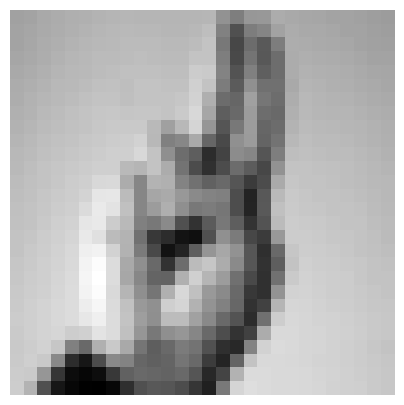

In [12]:
def plot_number(image):
    plt.figure(figsize=(5,5))
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

#Generates a random integer
rnd_idx = np.random.randint(len(y_test))

#Reshape array form 784*1 1D np.array   -->   28*28 2D np.array
# to make it possible to be plot as greyscale image
print("This is how a random selected array from dataset, converted to 28*28 image looks like")
plot_number(x_train[rnd_idx].reshape(28,28))


### Ecuaciones para nuestro modelo


$$z^1 = W^1 X + b^1$$

$$a^1 = ReLU(z^1) $$

$$z^2 = W^2 a^1 + b^2$$

$$\hat{y} = \frac{e^{z^{2_k}}}{\sum_j{e^{z_j}}}$$


$$ \mathcal{L}(\hat{y}^{i}, y^{i}) =  - y^{i}  \ln(\hat{y}^{i}) = -\ln(\hat{y}^i)$$


$$ \mathcal{J}(w, b) =  \frac{1}{num\_samples} \sum_{i=1}^{num\_samples}-\ln(\hat{y}^{i})$$

### Funciones adicionales

#### Mini batches

In [35]:
def create_minibatches(mb_size, x, y, shuffle = True):
    '''
    x  #muestras, 784
    y #muestras, 1
    '''
    assert x.shape[0] == y.shape[0], 'Error en cantidad de muestras'
    total_data = x.shape[0]
    if shuffle:
        idxs = np.arange(total_data)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

## Nuestra clase Linear, ReLU y Sequential

In [14]:
class np_tensor(np.ndarray): pass

In [15]:
a = np.array([0, 0])
b = a.view(np_tensor)

In [16]:
type(a)

numpy.ndarray

In [17]:
type(b)

__main__.np_tensor

In [18]:
a == b

np_tensor([ True,  True])

In [19]:
a is b

False

###  Clase Linear

In [20]:
class Linear():
    def __init__(self, input_size, output_size):
        '''
        Init parameters utilizando Kaiming He
        '''
        self.W = (np.random.randn(output_size, input_size) / np.sqrt(input_size/2)).view(np_tensor)
        self.b = (np.zeros((output_size, 1))).view(np_tensor)
    def __call__(self, X): # esta el foward de la clase lineal
        Z = self.W @ X + self.b
        return Z
    def backward(self, X, Z):
        X.grad = self.W.T @ Z.grad
        self.W.grad = Z.grad @ X.T
        self.b.grad = np.sum(Z.grad, axis = 1, keepdims=True)


### Clase ReLU

In [21]:
class ReLU():
    def __call__(self, Z):
        return np.maximum(0, Z)
    def backward(self, Z, A):
        Z.grad = A.grad.copy()
        Z.grad[Z <= 0] = 0

### Clase Sequential

In [22]:
class Sequential_layers():
    def __init__(self, layers):
        '''
        layers - lista que contiene objetos de tipo Linear, ReLU
        '''
        self.layers = layers
        self.x = None
        self.outputs = {}
    def __call__(self, X):
        self.x = X
        self.outputs['l0'] = self.x
        for i, layer in enumerate(self.layers, 1):
            self.x = layer(self.x)
            self.outputs['l'+str(i)]=self.x
        return self.x
    def backward(self):
        for i in reversed(range(len(self.layers))):
            self.layers[i].backward(self.outputs['l'+str(i)], self.outputs['l'+str(i+1)])
    def update(self, learning_rate = 1e-3):
        for layer in self.layers:
            if isinstance(layer, ReLU): continue
            layer.W = layer.W - learning_rate * layer.W.grad
            layer.b = layer.b - learning_rate * layer.b.grad
    def predict(self, X):
        return np.argmax(self.__call__(X))

### Cost Function

In [23]:
def softmaxXEntropy(x, y):
    batch_size = x.shape[1]
    exp_scores = np.exp(x)
    probs = exp_scores / exp_scores.sum(axis = 0)
    preds = probs.copy()
    # Costo
    y_hat = probs[y.squeeze(), np.arange(batch_size)]
    cost = np.sum(-np.log(y_hat)) / batch_size
    # Calcular gradientes
    probs[y.squeeze(), np.arange(batch_size)] -= 1 #dl/dx
    x.grad = probs.copy()

    return preds, cost

### Loop de entrenamiento

In [24]:
def train(model, epochs, mb_size=128, learning_rate = 1e-3):
    for epoch in range(epochs):
        for i, (x, y) in enumerate(create_minibatches(mb_size, x_train, y_train)):
            scores = model(x.T.view(np_tensor))
            _, cost = softmaxXEntropy(scores, y)
            model.backward()
            model.update(learning_rate)
        print(f'costo: {cost}, accuracy: {accuracy(x_val, y_val, mb_size)}')

In [25]:
def accuracy(x, y, mb_size):
    correct = 0
    total = 0
    for i, (x, y) in enumerate(create_minibatches(mb_size, x, y)):
        pred = model(x.T.view(np_tensor))
        correct += np.sum(np.argmax(pred, axis=0) == y.squeeze())
        total += pred.shape[1]
    return correct/total

In [26]:
#We need to change the output classes according to possible predictions (in this case 24 possible classes found on train_df)

#1st hidden layer
#Linear(784, 32) --> 784 inputs / 32 outputs
#ReLU() Activation type

#2nd hidden layer --> 32 inputs / 64 outputs. The inputs are the outputs of the first hidden layer
#Linear(32, 64)
#ReLU() Activation type

#3nd hidden layer --> 32 inputs / 64 outputs. The inputs are the outputs of the first hidden layer
#Linear(32, 64)
#ReLU() Activation type

#Classification layer  --> 128 inputs / 24 classes to predict
#Linear(128,24)

model = Sequential_layers([Linear(784, 32), ReLU(),
                            Linear(32, 64), ReLU(),
                            Linear(64, 128), ReLU(),
                            Linear(128,24)])

#mini batch size is mainly limited by the hardware we use for the training (OOM error will ocurr when exceeding)
# The smaller the batch size, the slower it takes to train
# Not necesarily the bigger the value, the better the accuracy
# Normally we use multiple of bytes (8, 32, 64, 128, 256, etc...)
mb_size = 256

# The smaller the learning rate is, the slower it takes to train
# Using a BIG learning rate is prompt to overfit
learning_rate = 0.0001

#50 epochs were needed to reach a decent level of accuracy using this fully connected network
epochs = 50


### Create your model and train it

In [36]:
train(model, epochs, mb_size, learning_rate)

AssertionError: ignored

---
Accuracy reached
---

In [ ]:
print((accuracy(x_test, y_test, mb_size))*100, '%')

75.0 %


### Test your model on Random data from your test set

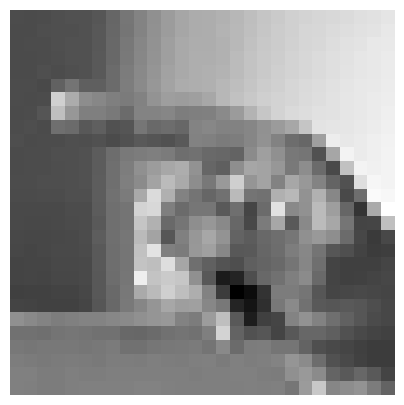

el valor predicho es: p el valor real es:p


In [ ]:
idx = np.random.randint(len(y_test))
plot_number(x_test[idx].reshape(28,28))
pred = model.predict(x_test[idx].reshape(-1, 1))
print(f'el valor predicho es: {alphabet[pred]} el valor real es:{alphabet[y_test[idx]]}')

---
Conclusion
---

We were able to reach a decent level of accuracy (>70%) NOT ONLY by tunning hyperparameters such as batch size, learning rate, epochs, etc. But we also modify the fully connected network architecture.